In [17]:
import bs4
import calendar
import re
import requests

import numpy as np

import xarray as xr

from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm as TQDM

In [27]:
%matplotlib inline

In [2]:
PARSER = 'lxml-html'

In [3]:
start = 'X-Body-of-Message'
end = 'X-Body-of-Message-End'

In [4]:
yr = 2017
mon = 8

In [5]:
num = 34

In [6]:
MONTH_INDEX_URL_MASK = 'https://www.lists.rdg.ac.uk/archives/met-jobs/{yr}-{mon:02d}/date.html'

In [7]:
MSG_URL_MASK = 'https://www.lists.rdg.ac.uk/archives/met-jobs/{yr}-{mon:02d}/{msg_href}'
# 'https://www.lists.rdg.ac.uk/archives/met-jobs/{yrmon:%Y-%m}/msg{num:05d}.html'

In [8]:
def get_msg_urls(year, month):
    msg_regex = 'msg([0-9]+)\.html'
    index_url = MONTH_INDEX_URL_MASK.format(yr=year, mon=month)
    r = requests.get(index_url)
    hrefs = []
    if r.status_code == 200:
        soup = bs4.BeautifulSoup(r.content, PARSER)
        for i in soup.find_all('a', href=re.compile(msg_regex)):
            hrefs += [i['href']]
    return hrefs

In [9]:
def extract_text_between_comments(soup, comm1, comm2):
    def _extract_text(node):
        return ''.join(t.strip() for t in node(text=True,
                                               recursive=False))
    comm1_tag = soup.find_all(text=comm1)[0]
    comm2_tag = soup.find_all(text=comm2)[0]
    after_comm1 = [*filter(None, [_extract_text(i) for i in comm1_tag.find_all_next()])]
    before_comm2 = [*filter(None, [_extract_text(i) for i in comm2_tag.find_all_previous()])]
    # elements_between = set(a.find_all_next()).intersection(b.find_all_previous())
    text = ''.join([s.strip() for s in after_comm1 if s in before_comm2 and len(s)>1])
    return text

In [10]:
def count_trigger(text, kwd):
    return kwd in text.lower()

In [11]:
year_range = range(2003, 2018)
month_range = range(1, 13)

In [12]:
kwd = 'python'

In [ ]:
data = np.zeros((len(year_range), len(month_range)))
for i, yr in tqdm(enumerate(year_range), desc='Loop over years'):
    for j, mon in tqdm(enumerate(month_range), desc='Loop over months'):
        hrefs = get_msg_urls(yr, mon)
        count = 0
        for href in tqdm(hrefs, desc='Loop within a month'):
            msg_url = MSG_URL_MASK.format(yr=yr, mon=mon, msg_href=href)
            req = requests.get(msg_url)
            if req.status_code == 200:
                soup = bs4.BeautifulSoup(req.content, PARSER)
                try:
                    txt = extract_text_between_comments(soup, start, end)
                    if count_trigger(txt, kwd):
                        count += 1
                except:
                    TQDM.write('WARNING!')
                    txt = ''
            data[i, j] = count

In [57]:
data[-1, -4:] = np.nan
data = np.ma.masked_invalid(data)

arr = xr.DataArray(data,
                   coords={'month': [i for i in month_range],
                           'year': year_range},
                   dims=('year', 'month'))

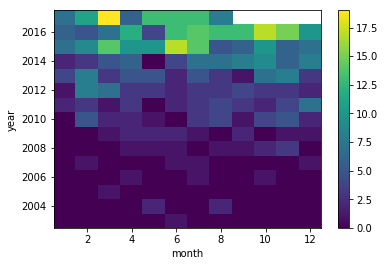

In [54]:
arr.plot.pcolormesh()

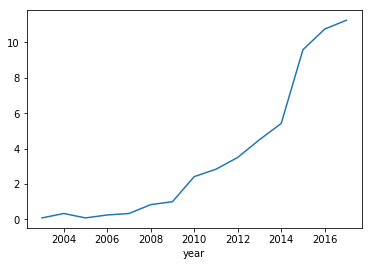

In [61]:
(arr.sum(axis=1) / (~data.mask).sum(axis=1)).plot()